In [1]:
#!pip install matplotlib
#!pip install pennylane
#!pip install qulacs pennylane-qulacs
#!pip install seaborn
#!pip install lightning
#!pip install ipynbname
#!pip install pandas
#!pip install yfinance==0.2.54
#!pip install --upgrade yfinance
#!pip show yfinance

In [2]:
#!pip install curl_cffi

In [3]:
import pandas as pd
import yfinance as yf
from curl_cffi import requests

session = requests.Session(impersonate="chrome")


#assets = "AAPL MSFT AMZN TSLA GOOG BRK-B IBM BAC BB NOK SONY"
#StockStartDate = '2024-01-01'
#StockEndDate = '2024-12-31'
#assets = "AAPL MSFT AMZN TSLA GOOG BRK-B"
#StockStartDate = '2018-01-01'
#StockEndDate = '2018-12-31'
#interval = '1d'
#yf.enable_debug_mode()
#df = yf.download(assets, start=StockStartDate,end=StockEndDate, interval=interval,auto_adjust=False,session=session)['Adj Close']
#df.to_feather("./portfolio12.dat")

df = pd.read_feather("./portfolio11") 
#print(df)
# daily return distribution
ret = df.pct_change().dropna()

# mean return vector & covariance matrix (annualized)
R = ret.mean()*252
Sigma = ret.cov()*252

In [4]:
import pennylane as qml
from pennylane import numpy as np

# define parameters in H
N = 6      # number of total assets
gamma = 1  # risk aversion coefficient
B = 3      # budget
P = 1.0    # penalty

ZZ = [qml.PauliZ(i)@qml.PauliZ(j) for i in range(N) for j in range(i+1,N)]
ZZ_coeff = [0.5*(gamma*Sigma.values[i][j] + P) for i in range(N) for j in range(i+1,N)]
Z = [qml.PauliZ(i) for i in range(N)]
Z_coeff = [-0.5*gamma*(sum(Sigma.values[i][:])) + 0.5*R[i] - 0.5*P*(N-2*B) for i in range(N)]
C = 0.25*gamma*(sum(sum(Sigma.values)) + np.trace(Sigma))- 0.5*sum(R) + 0.25*P*(N + (N-2*B)**2)

# Construct the problen Hamiltonian
obs = ZZ + Z
coeffs = ZZ_coeff + Z_coeff
H = qml.Hamiltonian(coeffs, obs, grouping_type="qwc")

C:\Users\User\AppData\Local\Temp\ipykernel_25900\1999095685.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Z_coeff = [-0.5*gamma*(sum(Sigma.values[i][:])) + 0.5*R[i] - 0.5*P*(N-2*B) for i in range(N)]


In [5]:
ground_energy = H.eigendecomposition['eigval'][0]

In [6]:
ground_energy

np.float64(-1.828877926348961)

In [7]:
# Design the ansatz
p = 2     # circuit repetitions
def ansatz(params, qubits, depth=p):
    for q in range(qubits):
            qml.RY(params[q], wires=q)
    for d in range(1,depth+1):
        for q in range(qubits-1):
            qml.CNOT(wires=[q,q+1])
        for q in range(qubits):
            qml.RY(params[d*qubits+q], wires=q)

In [8]:
dev = qml.device("lightning.qubit", wires=N)

# Set the cost function on dev
@qml.qnode(dev, diff_method="parameter-shift")
def cost(x):
    ansatz(x, qubits=N)
    return qml.expval(H)

# For analyze the optimized circuit
@qml.qnode(dev)
def probability_circuit(params):
    ansatz(params, qubits=N)
    return qml.probs(wires=range(N))

In [9]:

from pennylane import qaoa
from pennylane import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
from tqdm import tqdm
import pennylane as qml
#from pennylane import _flatten, unflatten
from pennylane import GradientDescentOptimizer
import copy
#from MomentumQNGOptimizer import MomentumQNGOptimizer 

In [10]:
def plot_opt_data(opt_delta_energy,opt_steps,opt_title,opt_color):
    fig = plt.figure(figsize=(12, 3), layout="compressed")
    axs = fig.subplots(1, 2, sharey=False)
    #fig, axs = plt.subplots(1, 4, sharey=False, tight_layout=False)
    
    # We can set the number of bins with the *bins* keyword argument.
    ave_delta_energy = 0
    for i in range(len(opt_delta_energy)):
        ave_delta_energy += opt_delta_energy[i]
    ave_delta_energy /= len(opt_delta_energy)   
    delta_bins = [i*0.04 for i in range(51)]
    steps_bins = [i for i in range(steps+1)]
    axs[0].hist(opt_delta_energy, bins=delta_bins,color=opt_color,label="mean(dE)=" + str(np.round(ave_delta_energy,3)))
    axs[1].hist(opt_steps, bins=steps_bins,color=opt_color)
    axs[0].set_xlabel("delta energy")
    axs[0].set_ylabel("count")
    axs[0].legend()
    axs[1].set_xlabel("steps")
    axs[1].set_ylabel("count")   
    plt.suptitle(opt_title)
    plt.show()

In [11]:
def run_session(optimizer,optimizer_params,init_params_array,steps):
    opt_params = []
    opt_steps = []
    opt_delta_energy = []
    #ground_energy = -1.9083156  -1.9083627666066187
    for init_params in tqdm(init_params_array):
        opt = copy.deepcopy(optimizer)
        for id in optimizer_params:
            setattr(opt, id, optimizer_params[id])
        params = init_params
        prev_cost = 9999.999999
        try:
            for i in range(steps):
                params = opt.step(cost, params)
                cur_cost = cost(params)
                if (i + 1) % 3 == 0:
                    if np.round(prev_cost, 3) == np.round(cur_cost, 3):
                        break
                    else:
                        prev_cost = cur_cost
            opt_params.append(params)
            opt_steps.append(i)
            opt_delta_energy.append(cur_cost - ground_energy)
        except:
            print(init_params)

    return (opt_params,opt_steps,opt_delta_energy)

In [12]:
lam = 0.5
momentum = 0.9
sessions = [
#    {"optimizer" : qml.QNGOptimizer(),
#     "params" : {"approx" : 'block-diag', "lam" : lam},
#     "params_name" : f"approx='block-diag', \N{GREEK SMALL LETTER LAMDA}={lam}",
#     "stepsizes" : [0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3]},
#    {"optimizer" :  qml.AdamOptimizer(),
#     "params" : {"beta1" : 0.9, "beta2" : 0.99, "epsilon" : 1.0e-8},
#     "params_name" : "$\mathit{"+ chr(946) + "}_1$=0.9, $\mathit{"+ chr(946) + "}_2$=0.99, $\mathit{"+ chr(949) +"}$=$10^{-8}$",
#     "stepsizes" : [0.01,0.1,0.2,0.3,0.4,0.5,0.75,1,1.25,15,1,75,2,2.25,2.5,2.75,3,3.25,3.5,3.75,4,4.25,4.5,4.75,5]},
    {"optimizer" :  qml.MomentumOptimizer(),
     "params" : {"momentum" : 0.9},
     "params_name" : "momentum=0.9",
     "stepsizes" : [0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1,1.05,1.1,1.15,1.2,1.25,1.3,1.35,1.4,1.45,1.5,1.55,1.6,1.65,1.7,1.75,1.8,1.85,1.9,1.95,2,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3]},
#    {"optimizer" :  qml.MomentumQNGOptimizer(),
#     "params" : {"momentum" : momentum,"approx" : 'block-diag', "lam" : lam},
#     "params_name" : f"\N{GREEK SMALL LETTER RHO}={momentum}, approx='block-diag', \N{GREEK SMALL LETTER LAMDA}={lam}",
#     "stepsizes" : [0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1,1.05,1.1,1.15,1.2,1.25,1.3,1.35,1.4,1.45,1.5,1.55,1.6,1.65,1.7,1.75,1.8,1.85,1.9,1.95,2,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3]}
]

In [13]:
sessions[0]["stepsizes"]

[0.01,
 0.05,
 0.1,
 0.15,
 0.2,
 0.25,
 0.3,
 0.35,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6,
 0.65,
 0.7,
 0.75,
 0.8,
 0.85,
 0.9,
 0.95,
 1,
 1.05,
 1.1,
 1.15,
 1.2,
 1.25,
 1.3,
 1.35,
 1.4,
 1.45,
 1.5,
 1.55,
 1.6,
 1.65,
 1.7,
 1.75,
 1.8,
 1.85,
 1.9,
 1.95,
 2,
 2.1,
 2.2,
 2.3,
 2.4,
 2.5,
 2.6,
 2.7,
 2.8,
 2.9,
 3]

In [14]:
init_count = 200
steps = 200

seed_value = 92736520

init_params_array = []
np.random.seed(seed_value)
for i in range(init_count):
    init_params_array.append(np.random.rand((p+1)*N))

100%|██████████| 200/200 [13:08<00:00,  3.94s/it]


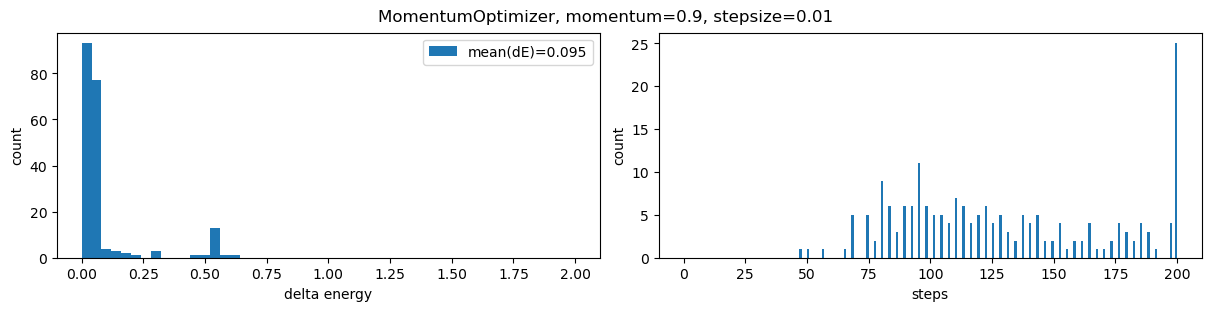

100%|██████████| 200/200 [07:02<00:00,  2.11s/it]


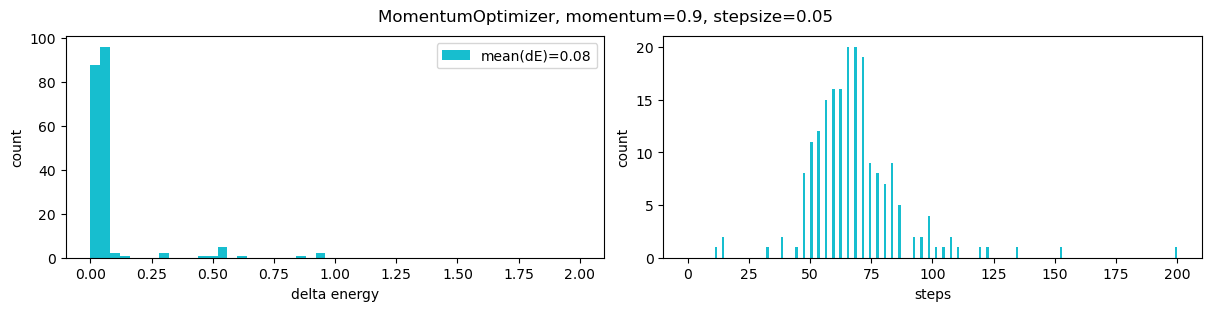

100%|██████████| 200/200 [06:28<00:00,  1.94s/it]


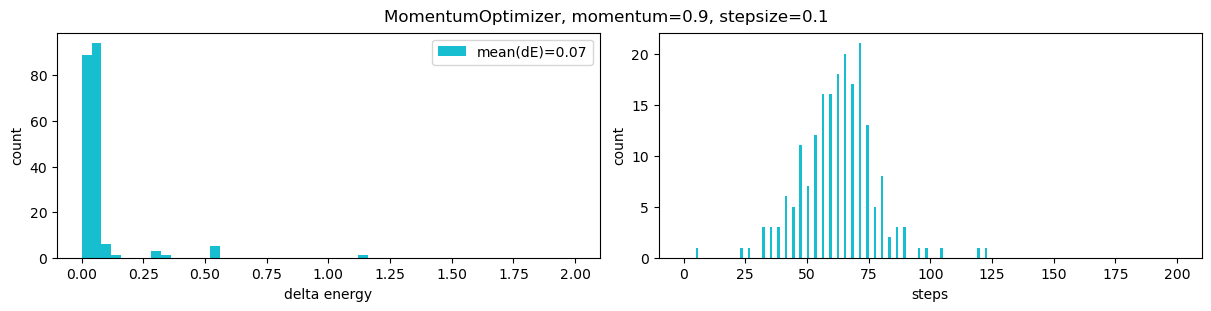

100%|██████████| 200/200 [06:29<00:00,  1.95s/it]


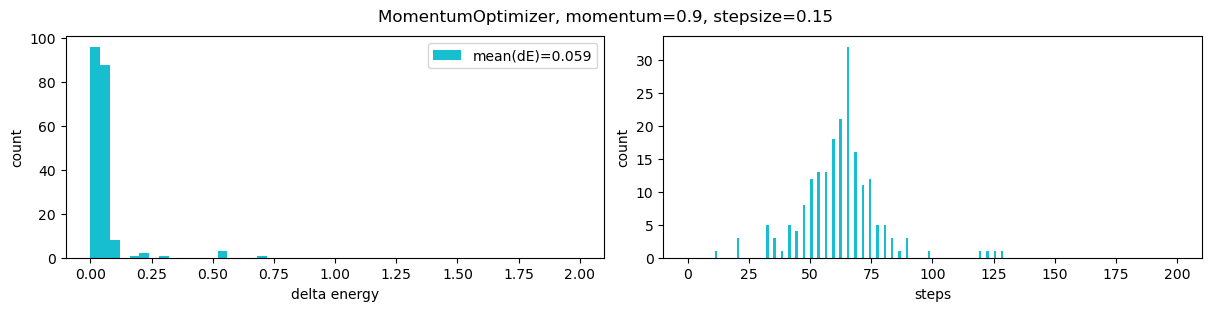

100%|██████████| 200/200 [06:28<00:00,  1.94s/it]


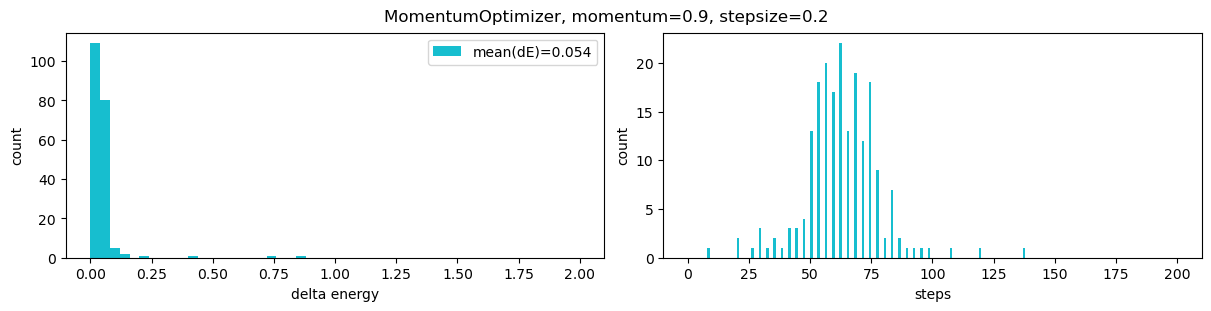

100%|██████████| 200/200 [06:18<00:00,  1.89s/it]


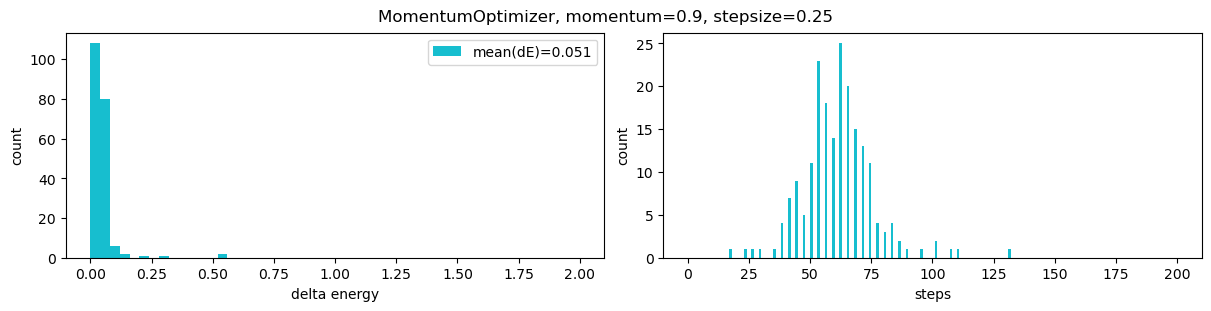

100%|██████████| 200/200 [06:09<00:00,  1.85s/it]


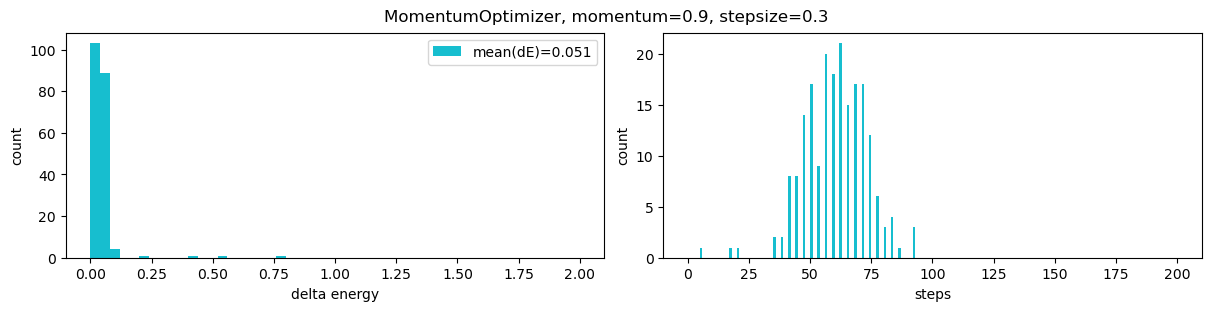

100%|██████████| 200/200 [06:19<00:00,  1.90s/it]


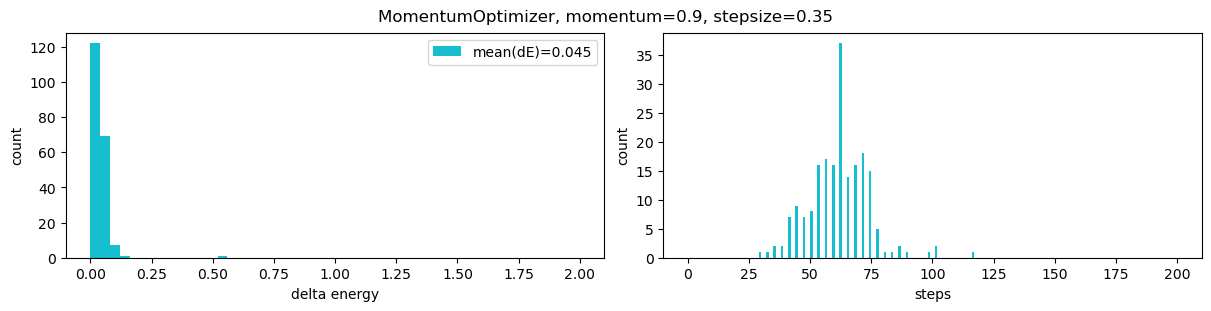

100%|██████████| 200/200 [06:06<00:00,  1.83s/it]


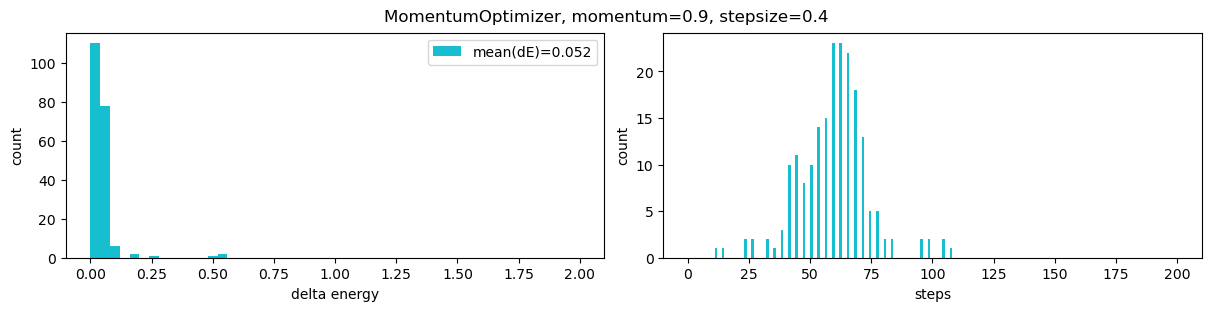

100%|██████████| 200/200 [05:58<00:00,  1.79s/it]


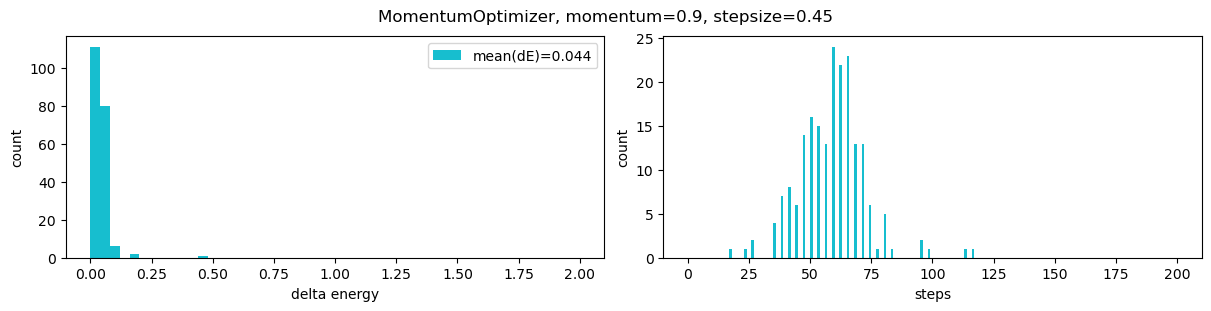

100%|██████████| 200/200 [06:06<00:00,  1.83s/it]


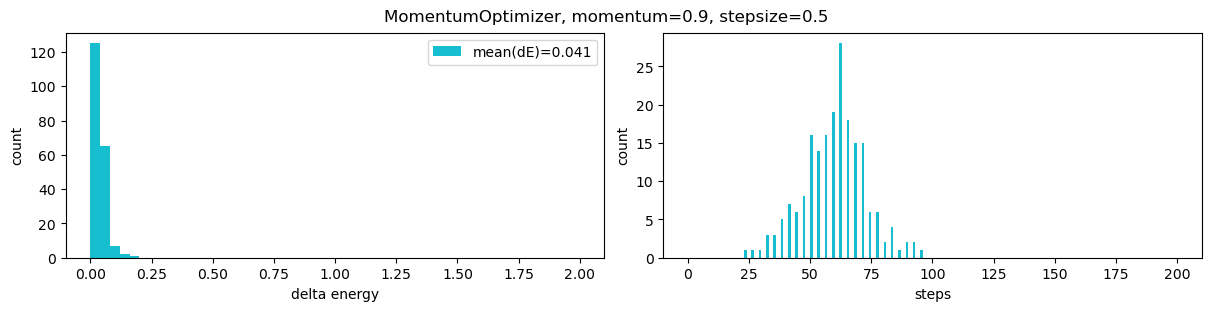

100%|██████████| 200/200 [05:49<00:00,  1.75s/it]


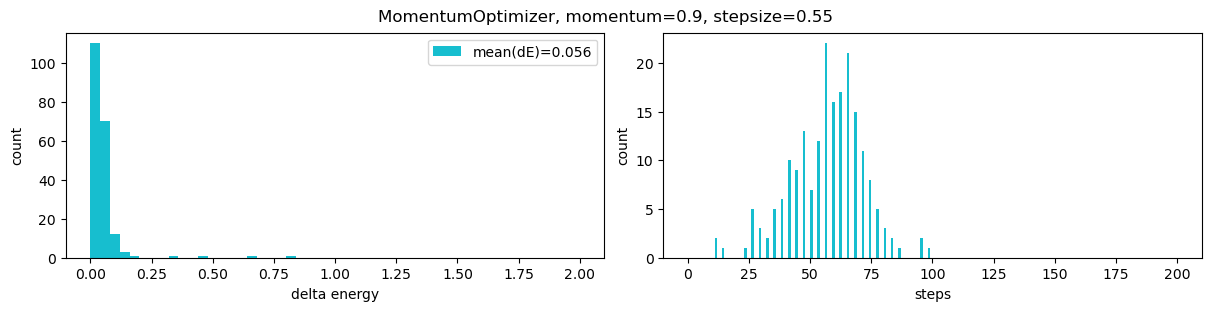

100%|██████████| 200/200 [06:03<00:00,  1.82s/it]


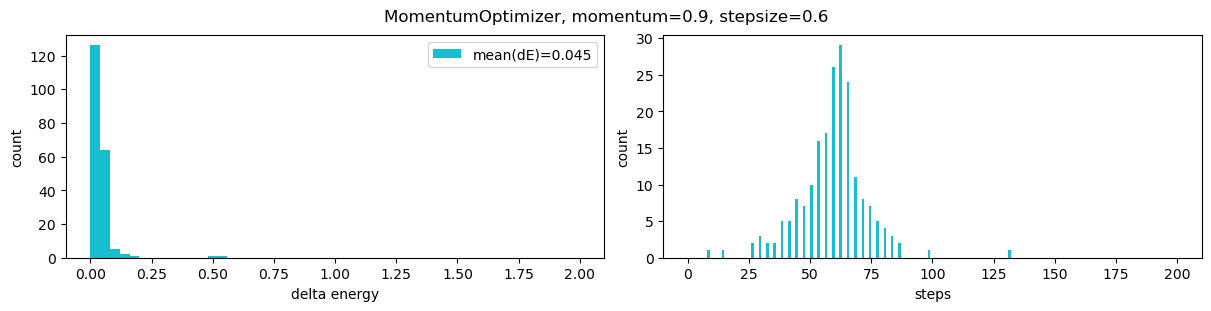

100%|██████████| 200/200 [06:04<00:00,  1.82s/it]


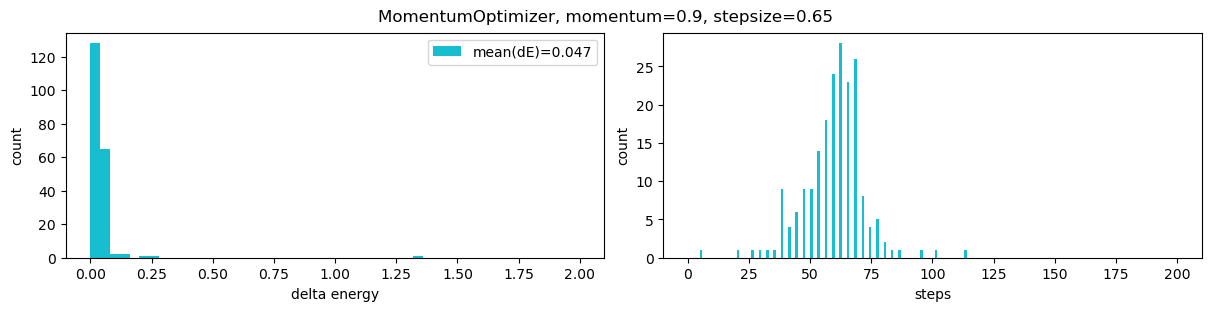

100%|██████████| 200/200 [06:07<00:00,  1.84s/it]


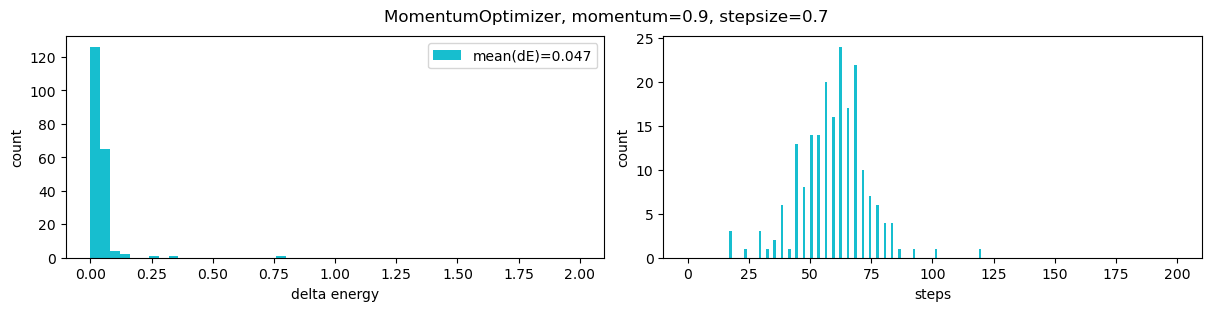

100%|██████████| 200/200 [06:15<00:00,  1.88s/it]


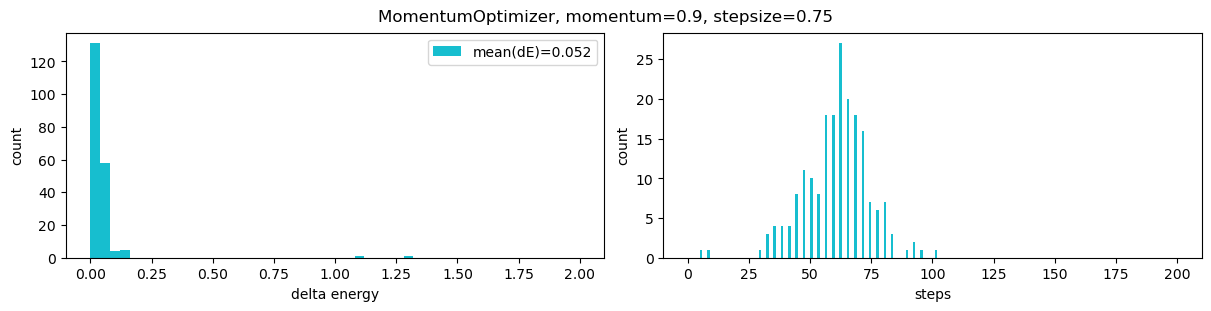

100%|██████████| 200/200 [06:21<00:00,  1.91s/it]


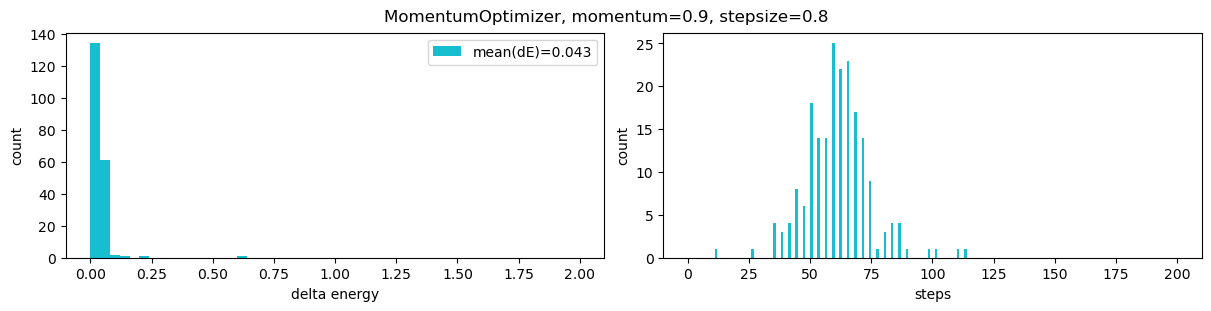

100%|██████████| 200/200 [06:15<00:00,  1.88s/it]


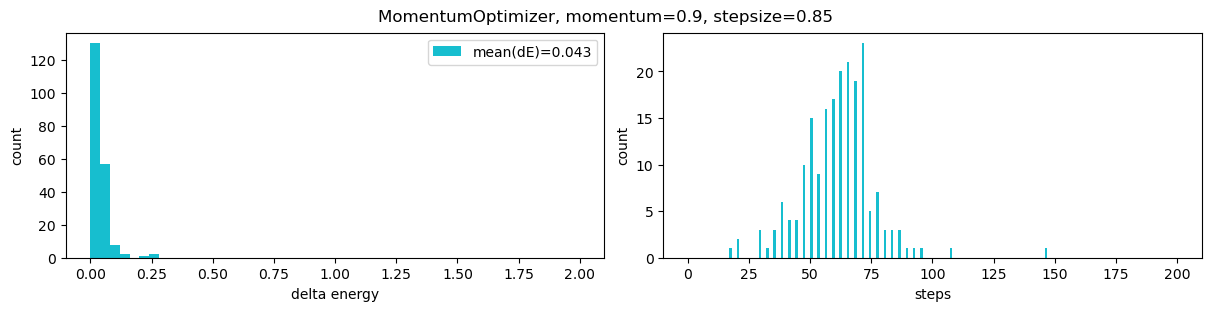

100%|██████████| 200/200 [06:38<00:00,  1.99s/it]


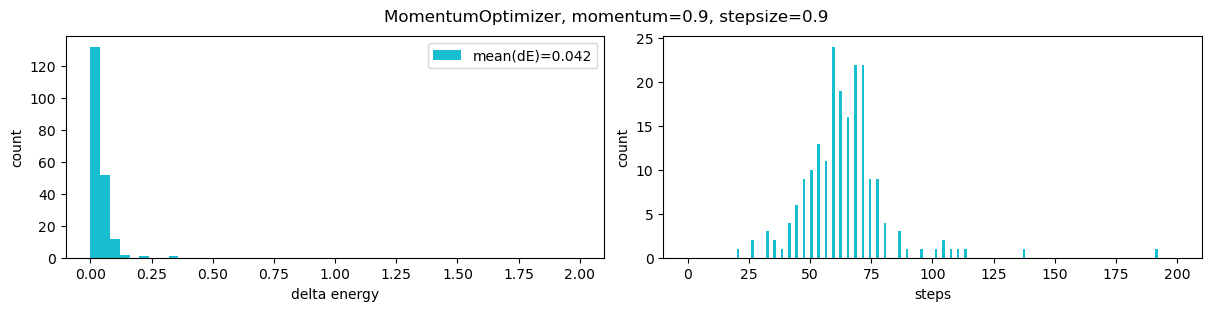

100%|██████████| 200/200 [06:42<00:00,  2.01s/it]


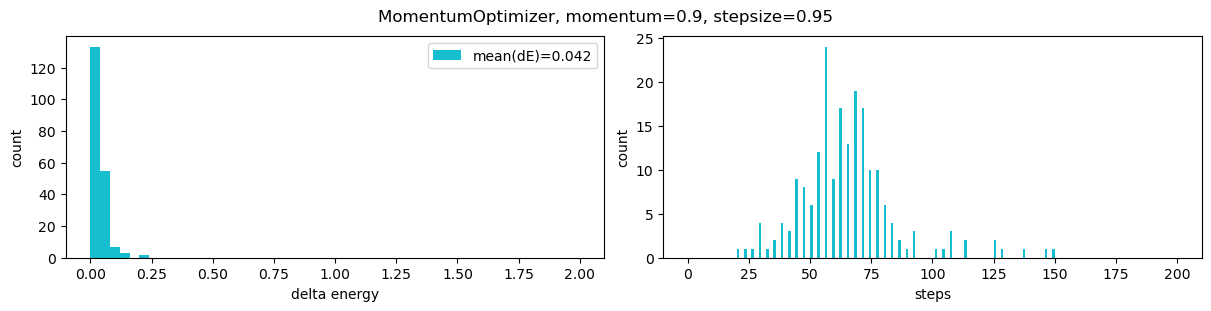

100%|██████████| 200/200 [06:57<00:00,  2.09s/it]


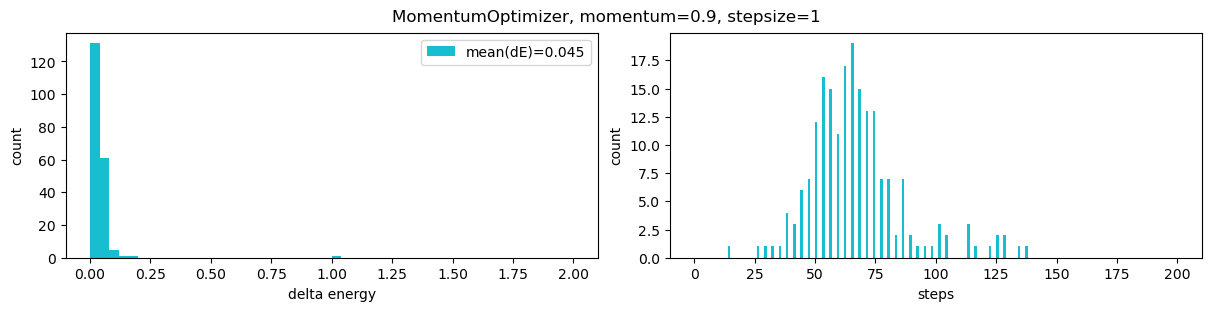

100%|██████████| 200/200 [06:48<00:00,  2.04s/it]


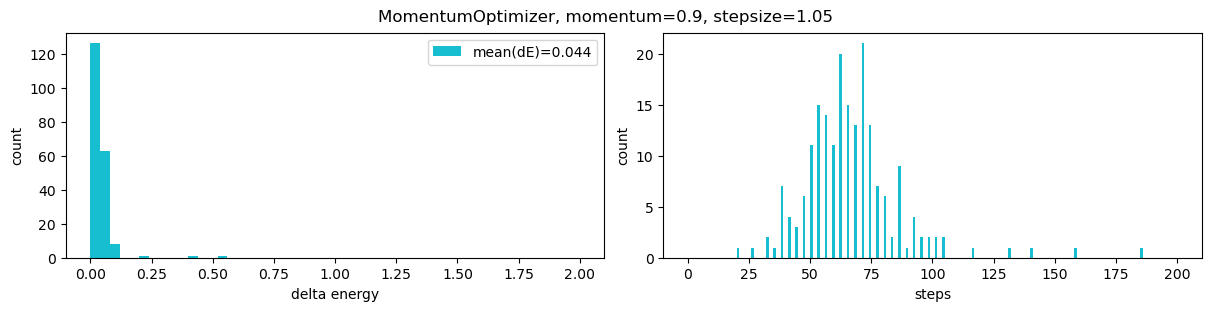

100%|██████████| 200/200 [07:14<00:00,  2.17s/it]


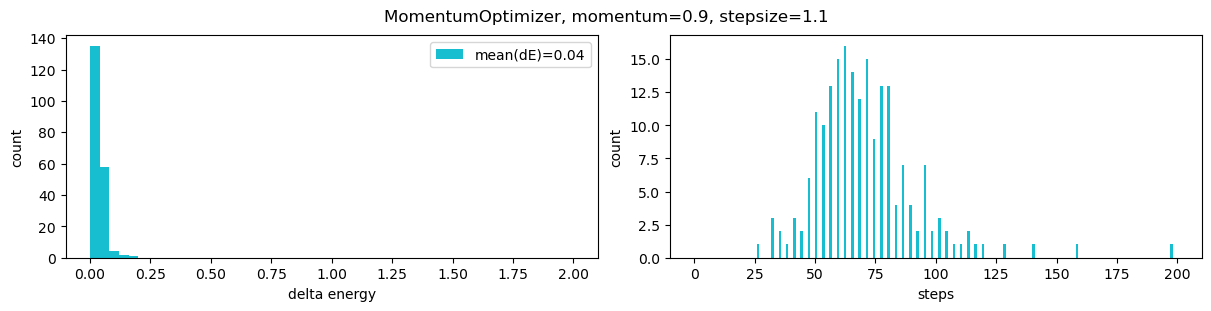

100%|██████████| 200/200 [07:29<00:00,  2.25s/it]


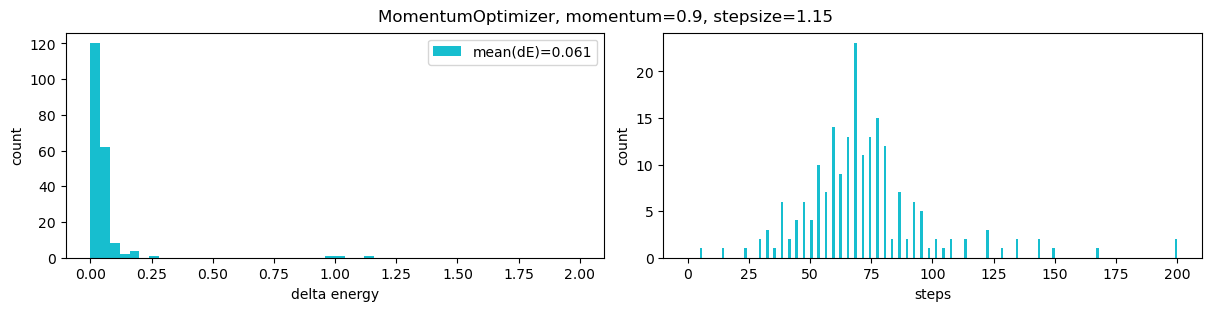

100%|██████████| 200/200 [08:17<00:00,  2.49s/it]


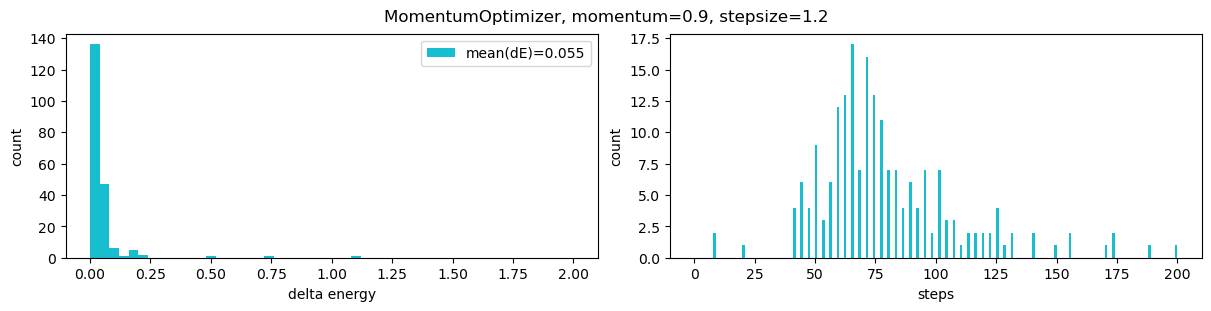

100%|██████████| 200/200 [08:22<00:00,  2.51s/it]


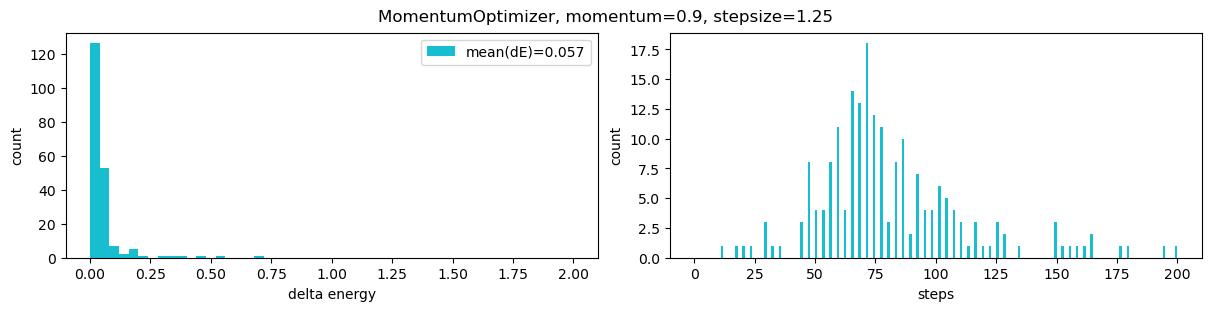

100%|██████████| 200/200 [09:33<00:00,  2.87s/it]


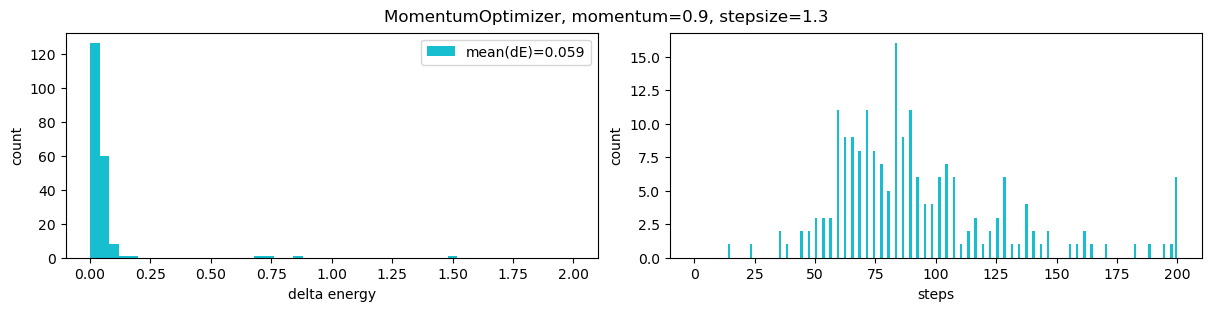

100%|██████████| 200/200 [10:21<00:00,  3.11s/it]


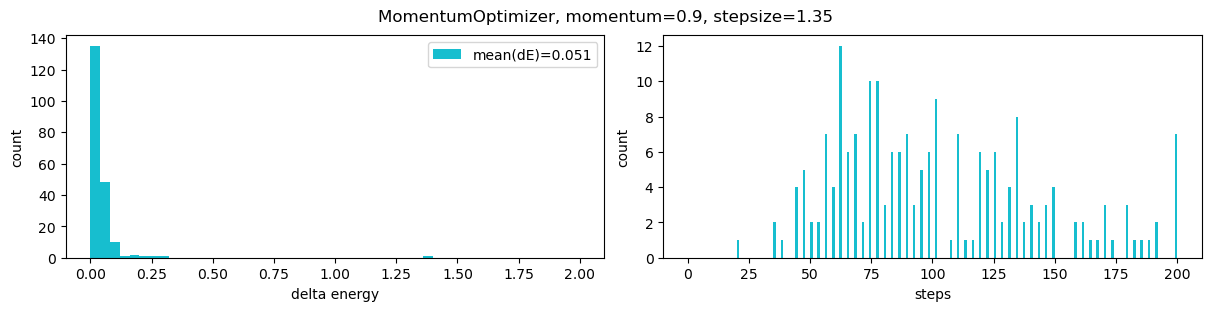

100%|██████████| 200/200 [12:33<00:00,  3.77s/it]


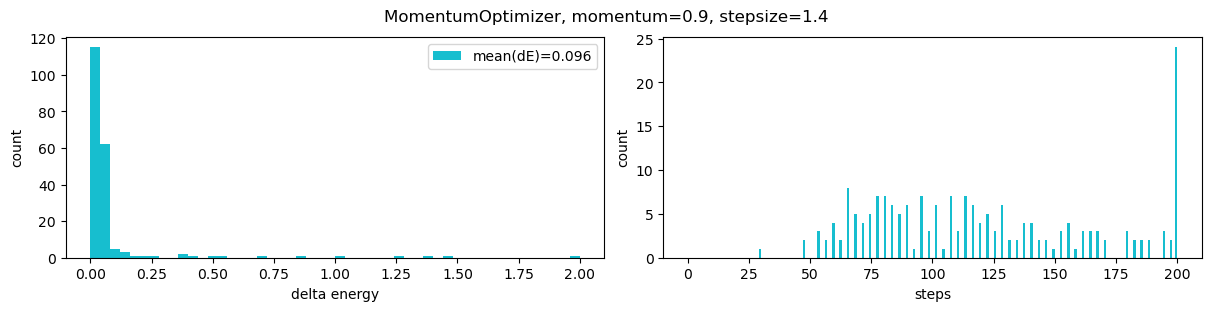

100%|██████████| 200/200 [12:09<00:00,  3.65s/it]


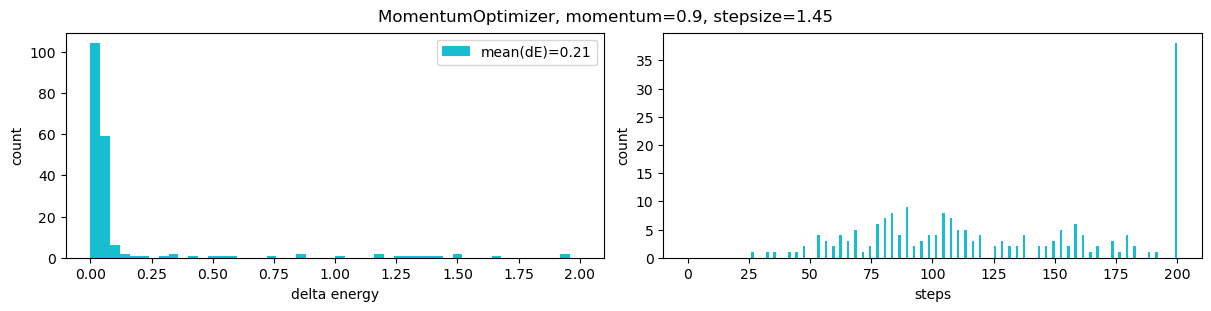

100%|██████████| 200/200 [14:20<00:00,  4.30s/it]


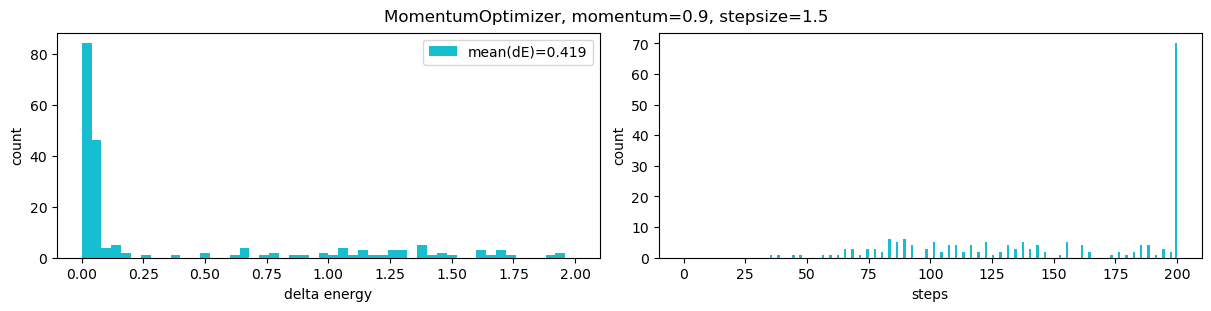

100%|██████████| 200/200 [15:53<00:00,  4.77s/it]


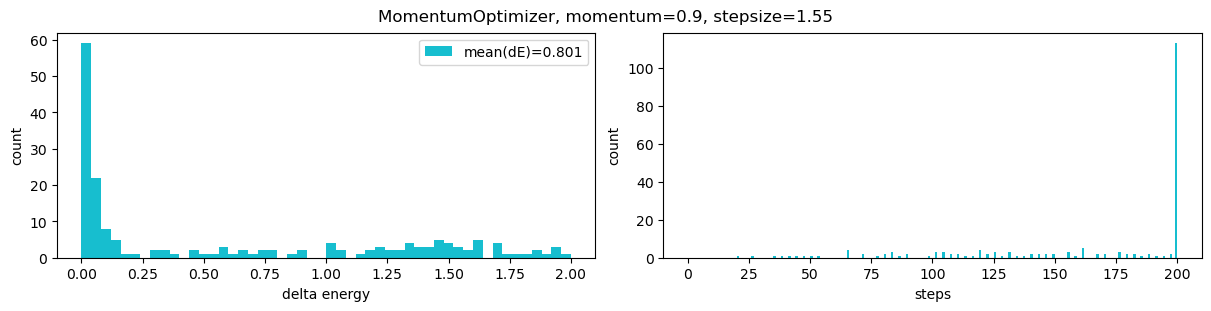

100%|██████████| 200/200 [17:02<00:00,  5.11s/it]


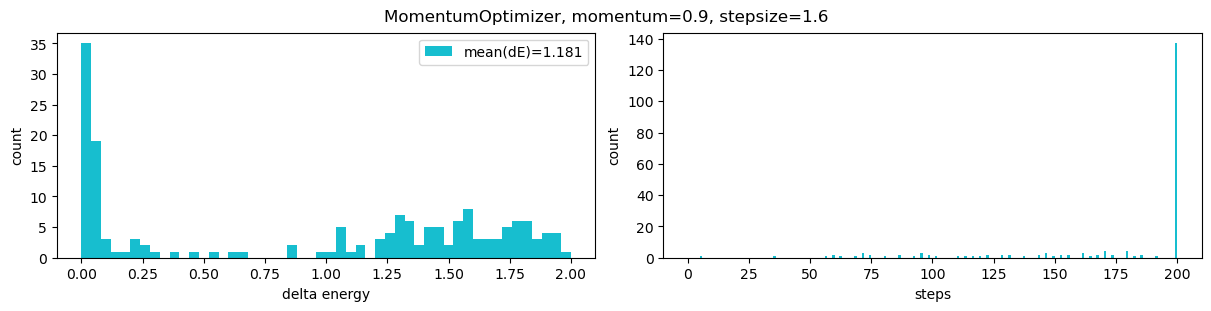

In [15]:
sessions_params = []
sessions_steps = []
sessions_delta_energy = []
max_delta_energy = 1.0
prev_delta_energy = 100.0
for i,session in enumerate(sessions):
    cur_params = []
    cur_steps = []
    cur_delta_energy = []
    act_stepsizes = []
    for stepsize in session["stepsizes"]:
        session_params = copy.deepcopy(session["params"])
        session_params["stepsize"] = stepsize
        (opt_params,opt_steps,opt_delta_energy) = run_session(session["optimizer"],session_params,init_params_array,steps)
        title = session["optimizer"].__class__.__name__
        if(len(session["params_name"]) > 0):
            title += ", "+ session["params_name"]
        title += ", stepsize=" + str(stepsize)
        plot_opt_data(opt_delta_energy,opt_steps,title,'C'+str(i))
        cur_params.append(opt_params)
        cur_steps.append(opt_steps)
        cur_delta_energy.append(opt_delta_energy)
        ave_delta_energy = 0
        for i in range(len(opt_delta_energy)):
            ave_delta_energy += opt_delta_energy[i]
        ave_delta_energy /= len(opt_delta_energy) 
        act_stepsizes.append(stepsize)
        if(ave_delta_energy > max_delta_energy):
            if(ave_delta_energy > prev_delta_energy):
               session["stepsizes"] = act_stepsizes
               break
        prev_delta_energy = ave_delta_energy
        #print(stepsize,ave_delta_energy, end='\r')
        
    sessions_params.append(cur_params)
    sessions_steps.append(cur_steps)
    sessions_delta_energy.append(cur_delta_energy)
    

\\?\C:\Users\User\AppData\Roaming\jupyterlab-desktop\envs\env_penelope\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


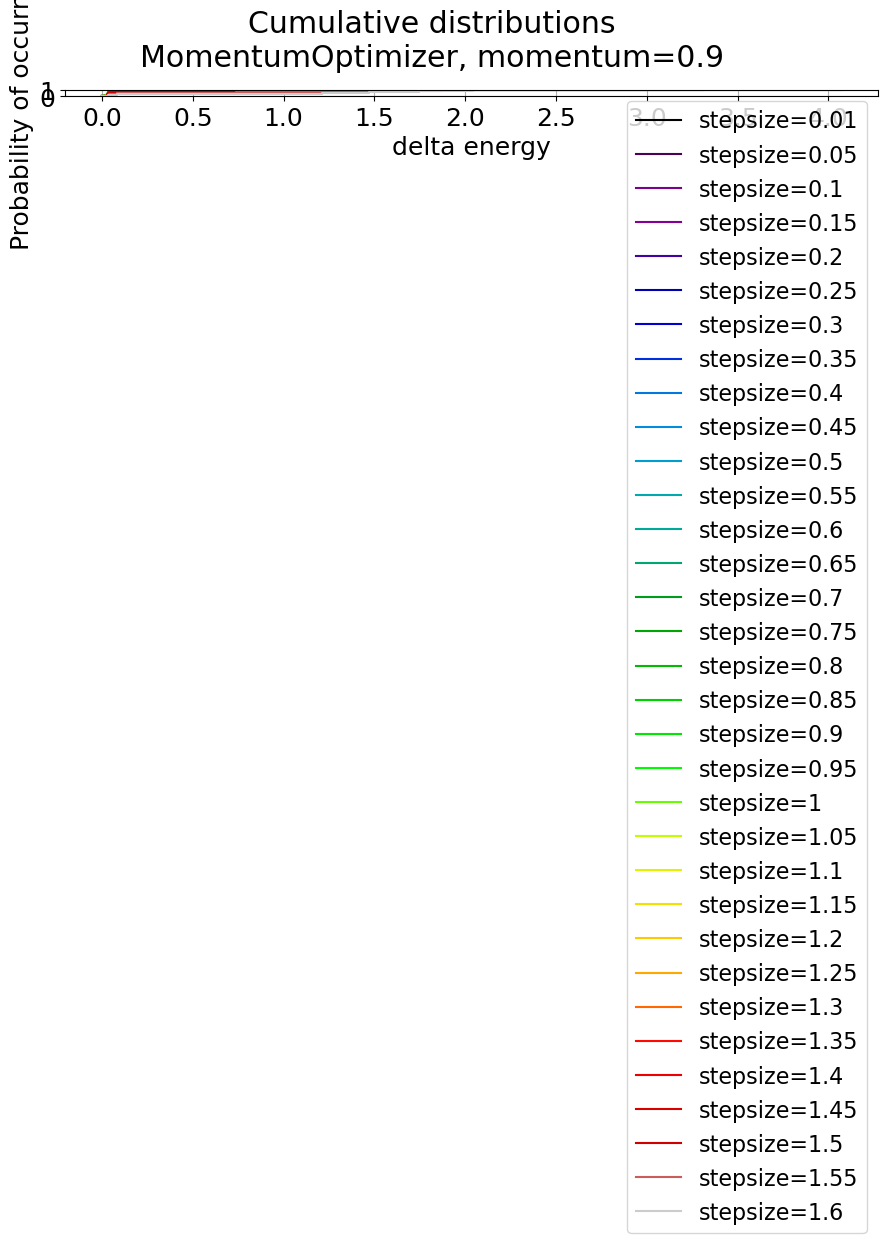

In [16]:
import matplotlib as mpl
from datetime import date
import ipynbname
#ground_energy = -1.9083156
mpl.rcParams['font.size'] = 18

prefix_name = ipynbname.name() + "_" + str(date.today()) + "_"

cmap = plt.colormaps['nipy_spectral']
colors = [cmap(i) for i in np.linspace(0, 1, len(sessions[0]["stepsizes"]))]

for i,session in enumerate(sessions):
    fig = plt.figure(figsize=(9, 7), layout="compressed")
    axs = fig.subplots(1, 1, sharex=True, sharey=True)
    
    # Cumulative distributions.
    
    for j,stepsize in enumerate(session["stepsizes"]):
        axs.ecdf(sessions_delta_energy[i][j],complementary=False, color=colors[j], label="stepsize="+str(stepsize) )
        
    # Label the figure.
    title = "Cumulative distributions\n" + session["optimizer"].__class__.__name__
    if(len(session["params_name"]) > 0):
        title += ", " + session["params_name"]
    
    fig.suptitle(title)
    
    axs.grid(True)
    axs.legend(fontsize=16)
    axs.set_xlabel("delta energy")
    axs.set_ylabel("Probability of occurrence")
    axs.label_outer()
    #axs.set_xlim(0.0, 1)
    plt.show()
    #fig.savefig(prefix_name + session["optimizer"].__class__.__name__+"_ccdf_quality.png",format='png',dpi=300)
    #fig.savefig(prefix_name + session["optimizer"].__class__.__name__+"_ccdf_quality.pdf",format='pdf',dpi=300)
    #fig.savefig(prefix_name + session["optimizer"].__class__.__name__+"_ccdf_quality.eps",format='eps',dpi=300)

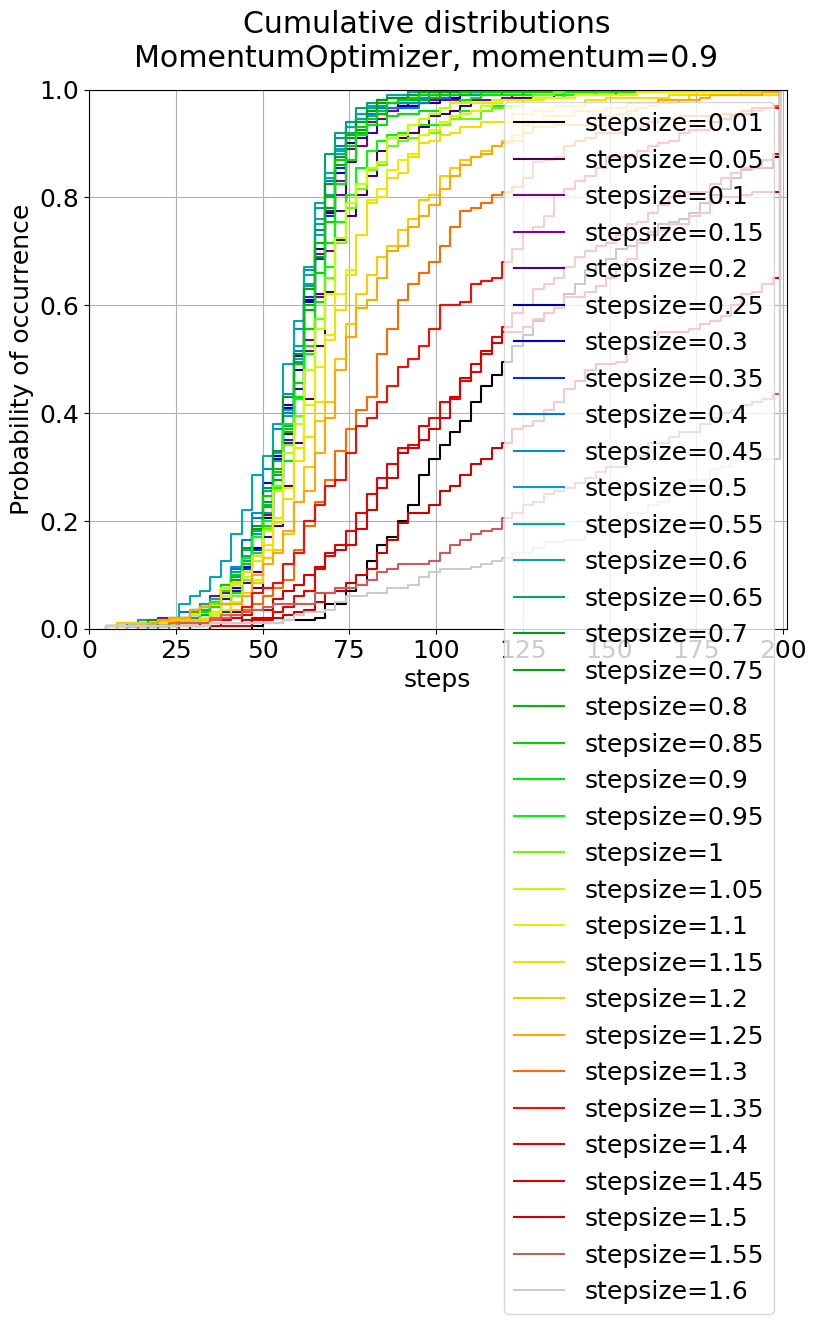

In [17]:
import matplotlib as mpl

cmap = plt.colormaps['nipy_spectral']
colors = [cmap(i) for i in np.linspace(0, 1, len(sessions[0]["stepsizes"]))]

for i,session in enumerate(sessions):
    fig = plt.figure(figsize=(9, 7), layout="compressed")
    axs = fig.subplots(1, 1, sharex=True, sharey=True)
    
    # Cumulative distributions.
    
    for j,stepsize in enumerate(session["stepsizes"]):
        axs.ecdf(sessions_steps[i][j],complementary=False, color=colors[j], label="stepsize="+str(stepsize) )
        
    # Label the figure.
    title = "Cumulative distributions\n" + session["optimizer"].__class__.__name__
    if(len(session["params_name"]) > 0):
        title += ", " + session["params_name"]
    
    fig.suptitle(title)
    
    axs.grid(True)
    axs.legend()
    axs.set_xlabel("steps")
    axs.set_ylabel("Probability of occurrence")
    axs.label_outer()
    axs.set_xlim(0.0, steps+1)
    plt.show()
    #fig.savefig(prefix_name + session["optimizer"].__class__.__name__+"_ccdf_steps.png",format='png',dpi=300)
    #fig.savefig(prefix_name + session["optimizer"].__class__.__name__+"_ccdf_steps.pdf",format='pdf',dpi=300)
    #fig.savefig(prefix_name + session["optimizer"].__class__.__name__+"_ccdf_steps.eps",format='eps',dpi=300)

In [18]:
'''
import matplotlib as mpl
mpl.rcParams['font.size'] = 11

fig = plt.figure(figsize=(9, 7), layout="compressed")
axs = fig.subplots(1, 1, sharex=True, sharey=True)

# Cumulative distributions.
cmap = mpl.colormaps['tab20b']
colors = cmap(np.linspace(0, 1, 20))

for j,stepsize in enumerate(sessions[0]["stepsizes"]):
    axs[0][0].ecdf(sessions_delta_energy[0][j],complementary=False, color=colors[j], label="stepsize="+str(stepsize) )
#for j,stepsize in enumerate(sessions[1]["stepsizes"]):
#    axs[0][1].ecdf(sessions_delta_energy[1][j],complementary=False, color=colors[j], label="stepsize="+str(stepsize) )
#for j,stepsize in enumerate(sessions[2]["stepsizes"]):
#    axs[1][1].ecdf(sessions_delta_energy[2][j],complementary=False, color=colors[j], label="stepsize="+str(stepsize) )
#for j,stepsize in enumerate(sessions[3]["stepsizes"]):
#    axs[1][0].ecdf(sessions_delta_energy[3][j],complementary=False, color=colors[j], label="stepsize="+str(stepsize) )

session_id = [0,1,3,2]
axs[0][0].text(0.85,0.07,"(a)",fontsize=16)
#axs[0][1].text(0.85,0.07,"(b)",fontsize=16)
#axs[1][0].text(0.85,0.07,"(c)",fontsize=16)
#axs[1][1].text(0.85,0.07,"(d)",fontsize=16)
fig.suptitle("Cumulative distributions")
for i in range(1):
    for j in range(1):
        axs[j][i].grid(True)
        axs[j][i].set_xlabel("delta energy")
        axs[j][i].set_ylabel("Probability of occurrence")
        axs[j][i].label_outer()
        axs[j][i].set_xlim(0.0, 1)
        axs[j][i].legend(loc="upper right",fontsize=8)
        session = sessions[session_id[i]] #*2+j]]
        title = session["optimizer"].__class__.__name__
        if(len(session["params_name"]) > 0):
            title += ", " + session["params_name"]
        axs[i][j].set_title(title)
        
plt.show()
#fig.savefig(prefix_name + "quality_ccdf.png",format='png',dpi=300)
#fig.savefig(prefix_name + "quality_ccdf.pdf",format='pdf',dpi=300)
#fig.savefig(prefix_name + "quality_ccdf.eps",format='eps',dpi=300)
'''

'\nimport matplotlib as mpl\nmpl.rcParams[\'font.size\'] = 11\n\nfig = plt.figure(figsize=(9, 7), layout="compressed")\naxs = fig.subplots(1, 1, sharex=True, sharey=True)\n\n# Cumulative distributions.\ncmap = mpl.colormaps[\'tab20b\']\ncolors = cmap(np.linspace(0, 1, 20))\n\nfor j,stepsize in enumerate(sessions[0]["stepsizes"]):\n    axs[0][0].ecdf(sessions_delta_energy[0][j],complementary=False, color=colors[j], label="stepsize="+str(stepsize) )\n#for j,stepsize in enumerate(sessions[1]["stepsizes"]):\n#    axs[0][1].ecdf(sessions_delta_energy[1][j],complementary=False, color=colors[j], label="stepsize="+str(stepsize) )\n#for j,stepsize in enumerate(sessions[2]["stepsizes"]):\n#    axs[1][1].ecdf(sessions_delta_energy[2][j],complementary=False, color=colors[j], label="stepsize="+str(stepsize) )\n#for j,stepsize in enumerate(sessions[3]["stepsizes"]):\n#    axs[1][0].ecdf(sessions_delta_energy[3][j],complementary=False, color=colors[j], label="stepsize="+str(stepsize) )\n\nsession_id 

In [19]:
'''
import matplotlib as mpl
mpl.rcParams['font.size'] = 11

fig = plt.figure(figsize=(9, 7), layout="compressed")
axs = fig.subplots(1, 1, sharex=True, sharey=True)

# Cumulative distributions.
cmap = mpl.colormaps['tab20b']
colors = cmap(np.linspace(0, 1, 20))

for j,stepsize in enumerate(sessions[0]["stepsizes"]):
    axs[0][0].ecdf(sessions_steps[0][j],complementary=False, color=colors[j], label="stepsize="+str(stepsize) )
#for j,stepsize in enumerate(sessions[1]["stepsizes"]):
#    axs[0][1].ecdf(sessions_steps[1][j],complementary=False, color=colors[j], label="stepsize="+str(stepsize) )
#for j,stepsize in enumerate(sessions[2]["stepsizes"]):
#    axs[1][1].ecdf(sessions_steps[2][j],complementary=False, color=colors[j], label="stepsize="+str(stepsize) )
#for j,stepsize in enumerate(sessions[3]["stepsizes"]):
#    axs[1][0].ecdf(sessions_steps[3][j],complementary=False, color=colors[j], label="stepsize="+str(stepsize) )

session_id = [0,1,3,2]

axs[0][0].text(175,0.07,"(a)",fontsize=16)
axs[0][1].text(175,0.07,"(b)",fontsize=16)
#axs[1][0].text(175,0.07,"(c)",fontsize=16)
#axs[1][1].text(175,0.07,"(d)",fontsize=16)
fig.suptitle("Cumulative distributions")
for i in range(1):
    for j in range(1):
        axs[j][i].grid(True)
        axs[j][i].set_xlabel("steps")
        axs[j][i].set_ylabel("Probability of occurrence")
        axs[j][i].label_outer()
        axs[j][i].set_xlim(0.0, steps+1)
        axs[j][i].legend(loc="upper right",fontsize=8)
        session = sessions[session_id[i]] #*2+j]]
        title = session["optimizer"].__class__.__name__
        if(len(session["params_name"]) > 0):
            title += ", " + session["params_name"]
        axs[i][j].set_title(title)
        
plt.show()
#fig.savefig(prefix_name + "steps_ccdf.png",format='png',dpi=300)
#fig.savefig(prefix_name + "steps_ccdf.pdf",format='pdf',dpi=300)
#fig.savefig(prefix_name + "steps_ccdf.eps",format='eps',dpi=300)
'''

'\nimport matplotlib as mpl\nmpl.rcParams[\'font.size\'] = 11\n\nfig = plt.figure(figsize=(9, 7), layout="compressed")\naxs = fig.subplots(1, 1, sharex=True, sharey=True)\n\n# Cumulative distributions.\ncmap = mpl.colormaps[\'tab20b\']\ncolors = cmap(np.linspace(0, 1, 20))\n\nfor j,stepsize in enumerate(sessions[0]["stepsizes"]):\n    axs[0][0].ecdf(sessions_steps[0][j],complementary=False, color=colors[j], label="stepsize="+str(stepsize) )\n#for j,stepsize in enumerate(sessions[1]["stepsizes"]):\n#    axs[0][1].ecdf(sessions_steps[1][j],complementary=False, color=colors[j], label="stepsize="+str(stepsize) )\n#for j,stepsize in enumerate(sessions[2]["stepsizes"]):\n#    axs[1][1].ecdf(sessions_steps[2][j],complementary=False, color=colors[j], label="stepsize="+str(stepsize) )\n#for j,stepsize in enumerate(sessions[3]["stepsizes"]):\n#    axs[1][0].ecdf(sessions_steps[3][j],complementary=False, color=colors[j], label="stepsize="+str(stepsize) )\n\nsession_id = [0,1,3,2]\n\naxs[0][0].tex

In [20]:
#for i,session in enumerate(sessions):
#    session["params_name"] = "lambda=" + str(session["params"]["lam"])

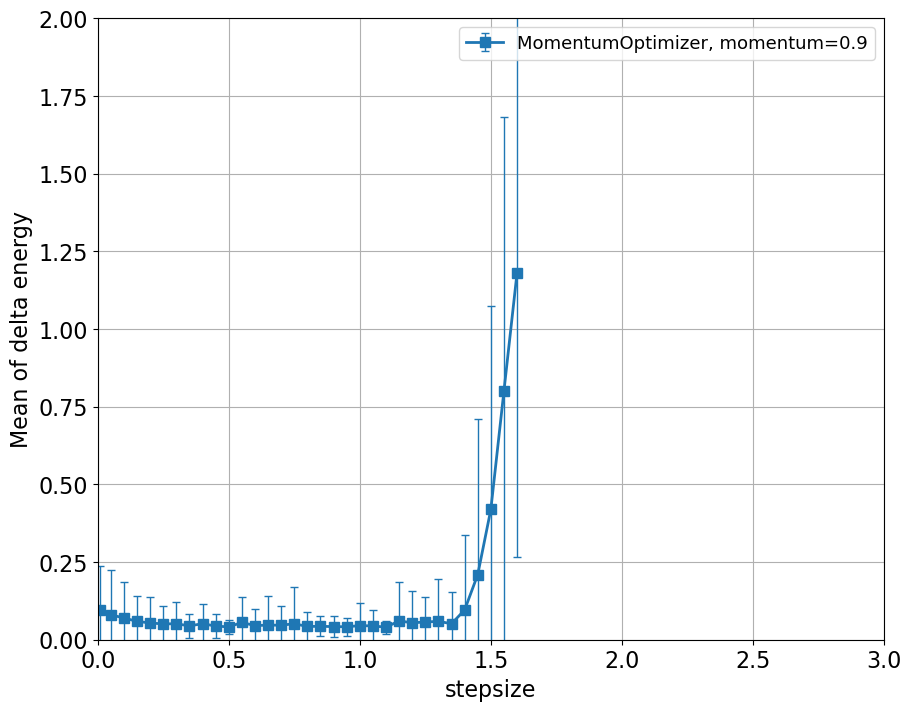

In [21]:
import matplotlib as mpl
import statistics
import math
import torch

mpl.rcParams['font.size'] = 16

cmap = plt.colormaps['nipy_spectral']
colors = [cmap(i) for i in np.linspace(0, 1, len(sessions[0]["stepsizes"]))]
fig = plt.figure(figsize=(9, 7), layout="compressed")
axs = fig.subplots(1, 1, sharex=True, sharey=True)
#axs.text(0.015,-0.015,"(a)",fontsize=28)
format_plot = ["s-","o-","v-","^-"]
for i,session in enumerate(sessions):
    ave_session = []
    stdev_session = []
    for j,stepsize in enumerate(session["stepsizes"]):
        delta = []
        for k in range(len(sessions_delta_energy[i][j])):
            delta.append(float(sessions_delta_energy[i][j][k]))
        ave_val = statistics.mean(delta)
        stdev_val = statistics.stdev(delta)
        ave_session.append(ave_val)
        if(stdev_val == 'NaN'):
            stdev_val = 0
        stdev_session.append(stdev_val)
    label = session["optimizer"].__class__.__name__
    if(len(session["params_name"]) > 0):
        label += ", " + session["params_name"]
    axs.errorbar(session["stepsizes"],ave_session,yerr=stdev_session,elinewidth=1,label=label,capsize=3,fmt=format_plot[i],ms=7,lw=2)
  
    axs.grid(True)
    axs.legend(fontsize=13)
    axs.set_xlabel("stepsize")
    axs.set_ylabel("Mean of delta energy")
    #axs.label_outer()
    axs.set_xlim(0.0, 3)
    axs.set_ylim(0.0, 2)
plt.show()
fig.savefig(prefix_name + session["optimizer"].__class__.__name__+"_ave_quality.png",format='png',dpi=300)
#fig.savefig(prefix_name + session["optimizer"].__class__.__name__+"_ave_quality.pdf",format='pdf',dpi=300)
#fig.savefig(prefix_name + session["optimizer"].__class__.__name__+"_ave_quality.eps",format='eps',dpi=300)

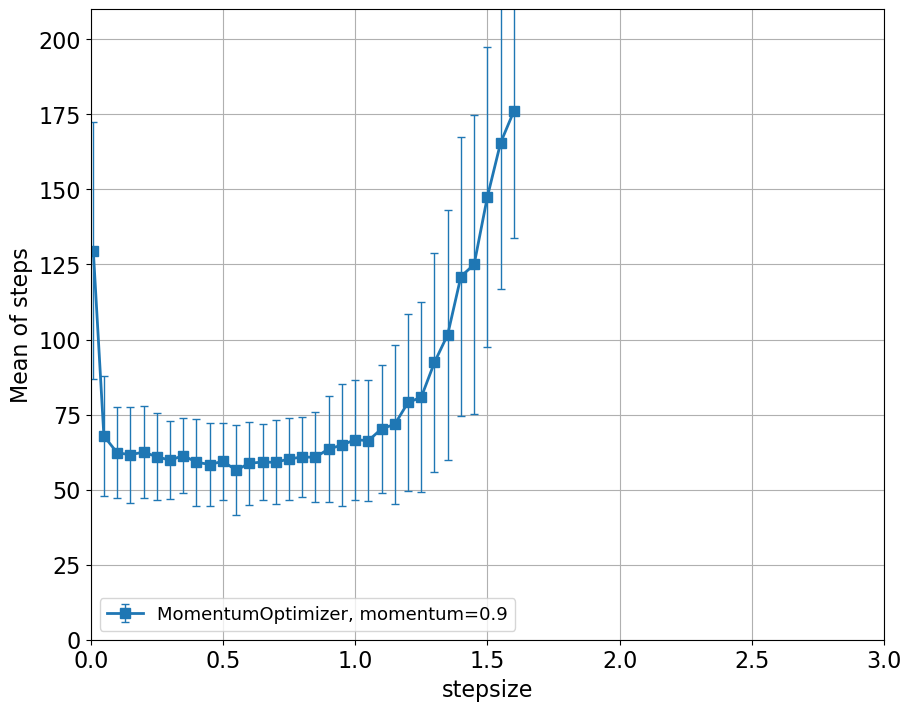

In [22]:
import matplotlib as mpl
import statistics
import math
import torch

cmap = plt.colormaps['nipy_spectral']
colors = [cmap(i) for i in np.linspace(0, 1, len(sessions[0]["stepsizes"]))]

fig = plt.figure(figsize=(9, 7), layout="compressed")
axs = fig.subplots(1, 1, sharex=True, sharey=True)
#axs.text(0.015,10.0,"(b)",fontsize=28)
format_plot = ["s-","o-","v-","^-"]
for i,session in enumerate(sessions):
    ave_session = []
    stdev_session = []
    for j,stepsize in enumerate(session["stepsizes"]):
        arr_steps = []
        for k in range(len(sessions_steps[i][j])):
            arr_steps.append(float(sessions_steps[i][j][k]))
        ave_val = statistics.mean(arr_steps)
        stdev_val = statistics.stdev(arr_steps)
        ave_session.append(ave_val)
        if(stdev_val == 'NaN'):
            stdev_val = 0
        stdev_session.append(stdev_val)
    label = session["optimizer"].__class__.__name__
    if(len(session["params_name"]) > 0):
        label += ", " + session["params_name"]
    axs.errorbar(session["stepsizes"],ave_session,yerr=stdev_session,elinewidth=1,label=label,capsize=3,fmt=format_plot[i],ms=7,lw=2)
  
    axs.grid(True)
    axs.legend(fontsize=13)
    axs.set_xlabel("stepsize")
    axs.set_ylabel("Mean of steps")
    #axs.label_outer()
    axs.set_xlim(0.0, 3)
    axs.set_ylim(0.0, 210)
plt.show()
fig.savefig(prefix_name + session["optimizer"].__class__.__name__+"_ave_steps.png",format='png',dpi=300)
#fig.savefig(prefix_name + session["optimizer"].__class__.__name__+"_ave_steps.pdf",format='pdf',dpi=300)
#fig.savefig(prefix_name + session["optimizer"].__class__.__name__+"_ave_steps.eps",format='eps',dpi=300)

In [23]:
from datetime import date
import ipynbname


start_name = ipynbname.name() + "_"
tail_name = "_" + str(date.today()) + ".dat"
with open(start_name + "delta_energy" + tail_name, "w") as file:
    for j in range(len(init_params_array)):
        line = ""
        for i in range(len(sessions)):
            for k in range(len(sessions[i]["stepsizes"])):
                try:
                    line += str(sessions_delta_energy[i][k][j]) + " "
                except:
                    print(j)
        print(j,line,file=file)

with open(start_name + "steps" + tail_name, "w") as file:
    for j in range(len(init_params_array)):
        line = ""
        for i in range(len(sessions)):
            for k in range(len(sessions[i]["stepsizes"])):
                try:
                    line += str(sessions_steps[i][k][j]) + " "
                except:
                    print(j)
        print(j,line,file=file)

with open(start_name + "params" + tail_name, "w") as file:
    for j in range(len(init_params_array)):
        line = ""
        for i in range(len(sessions)):
            for k in range(len(sessions[i]["stepsizes"])):
                try:
                    line += str(sessions_params[i][k][j][0]) + " " + str(sessions_params[i][k][j][1]) + " "
                except:
                    print(j)
        print(j,line,file=file)
